In [4]:
import ipywidgets as widgets
from IPython.display import display

# Create a text box widget for the S3 bucket name
bucket_name_widget = widgets.Text(
    value='',
    placeholder='Enter your S3 bucket name here',
    description='Bucket:',
    disabled=False
)

# Create a button to confirm the bucket name
button = widgets.Button(description="Set Bucket Name")
output = widgets.Output()

def on_button_click(b):
    global bucket_name
    bucket_name = bucket_name_widget.value
    with output:
        output.clear_output()
        print(f"S3 bucket name set to: {bucket_name}")

button.on_click(on_button_click)

# Align the button with the text box
ui = widgets.HBox([bucket_name_widget, button])

# Display the aligned UI elements and output
display(ui, output)


Output()

In [5]:
import boto3
import io

def fetch_dicom_files(bucket_name):
    s3 = boto3.client('s3')
    try:
        response = s3.list_objects_v2(Bucket=bucket_name)
        if 'Contents' not in response:
            return [], 'No DICOM files found in the bucket.'

        dicom_files = [obj['Key'] for obj in response['Contents'] if obj['Key'].endswith('.dcm')]
        return dicom_files, None
    except Exception as e:
        return [], str(e)

# Fetch and display the first few DICOM files
dicom_files, error = fetch_dicom_files(bucket_name)

if error:
    print(f"Error fetching DICOM files: {error}")
else:
    if len(dicom_files) == 0:
        print("No DICOM files found in the bucket.")
    else:
        print(f"Successfully fetched {len(dicom_files)} DICOM files.")
        print("Here are the first few DICOM files:")
        for dicom_file in dicom_files[:5]:  # Display the first 5 DICOM files
            print(dicom_file)


Successfully fetched 11 DICOM files.
Here are the first few DICOM files:
1-001.dcm
1-002.dcm
1-003.dcm
1-004.dcm
1-005.dcm


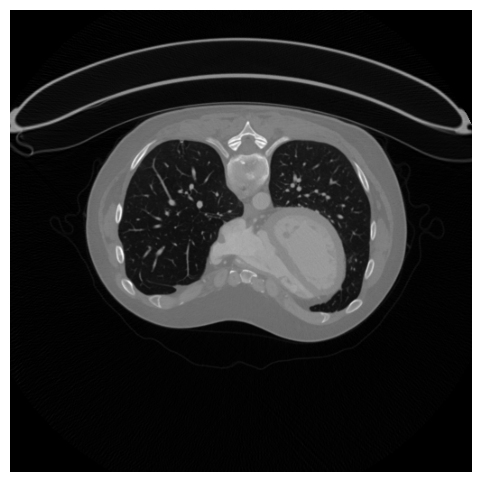

In [6]:
import matplotlib.pyplot as plt
import pydicom

def download_dicom_file(bucket_name, dicom_key):
    s3 = boto3.client('s3')
    try:
        response = s3.get_object(Bucket=bucket_name, Key=dicom_key)
        dicom_file = io.BytesIO(response['Body'].read())
        return pydicom.dcmread(dicom_file), None
    except Exception as e:
        return None, str(e)

def visualize_dicom(bucket_name, dicom_key):
    dicom_data, error = download_dicom_file(bucket_name, dicom_key)
    if error:
        print(f"Error downloading DICOM file: {error}")
    else:
        plt.figure(figsize=(6, 6))
        plt.imshow(dicom_data.pixel_array, cmap=plt.cm.gray)
        plt.axis('off')
        plt.show()

# Example: Visualize the first DICOM file in the list
if dicom_files:
    visualize_dicom(bucket_name, dicom_files[0])


Dropdown(description='Select DICOM:', options=('1-001.dcm', '1-002.dcm', '1-003.dcm', '1-004.dcm', '1-005.dcm'…

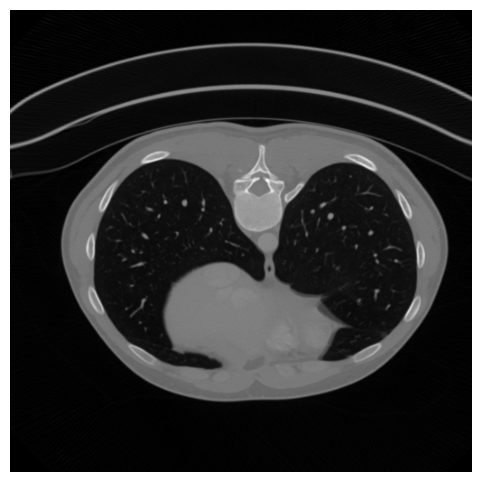

In [7]:
import ipywidgets as widgets
from IPython.display import display

# Create a dropdown widget for selecting a DICOM file
dropdown = widgets.Dropdown(
    options=dicom_files,
    description='Select DICOM:',
    disabled=False,
)

def on_select_change(change):
    visualize_dicom(bucket_name, change['new'])

# Set up the observer for the dropdown selection
dropdown.observe(on_select_change, names='value')

# Display the dropdown widget
display(dropdown)


FloatSlider(value=1.0, continuous_update=False, description='Contrast:', max=2.0, min=0.5)

FloatSlider(value=0.0, continuous_update=False, description='Brightness:', min=-100.0, step=10.0)

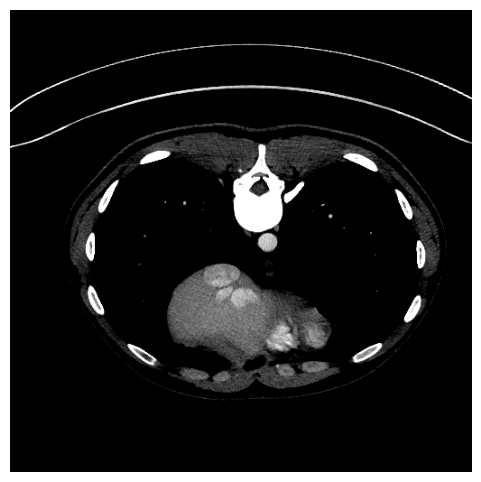

In [9]:
import numpy as np

# Create sliders for contrast and brightness
contrast_slider = widgets.FloatSlider(
    value=1.0,
    min=0.5,
    max=2.0,
    step=0.1,
    description='Contrast:',
    continuous_update=False
)

brightness_slider = widgets.FloatSlider(
    value=0.0,
    min=-100,
    max=100,
    step=10,
    description='Brightness:',
    continuous_update=False
)

def update_image(change):
    # Adjust contrast and brightness
    dicom_data, _ = download_dicom_file(bucket_name, dropdown.value)
    image = dicom_data.pixel_array
    adjusted_image = np.clip(contrast_slider.value * image + brightness_slider.value, 0, 255)
    
    # Display the adjusted image
    plt.figure(figsize=(6, 6))
    plt.imshow(adjusted_image, cmap=plt.cm.gray)
    plt.axis('off')
    plt.show()

# Update the image when sliders change
contrast_slider.observe(update_image, names='value')
brightness_slider.observe(update_image, names='value')

# Display sliders
display(contrast_slider, brightness_slider)
